# Implementation of Magic Window Logic

### Predicting a future opening price from the previous year of open, high, low, and close prices as well as the volume

In [312]:
import numpy as np
from datetime import datetime
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras import metrics
from keras import backend as K
from attention import Attention
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import plot_model
plt.style.use('seaborn')

In [313]:
ticker = '^GSPC'
exposureSize = 365
lookAhead = 1
numEpochs = 12
batchSize = 32

(8218,)
(8218,)
(8218,)
(8218,)
(8218,)
(8218, 5)


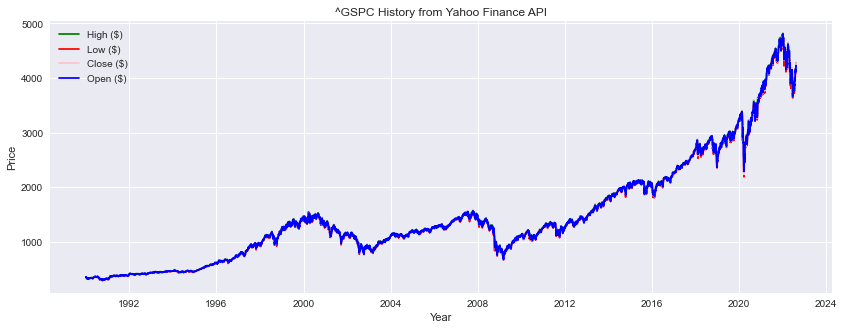

In [331]:
target = yf.Ticker(ticker)
today = datetime.now().date().strftime("%Y-%m-%d")
history = target.history(start="1990-01-01", end=today)
opens = history.Open
highs = history.High
lows = history.Low
closes = history.Close
volume = history.Volume
data = pd.concat([opens, highs, lows, closes, volume], axis=1)
data.dropna(inplace=True, axis=0)

print(opens.shape)
print(highs.shape)
print(lows.shape)
print(closes.shape)
print(volume.shape)
print(data.shape)

plt.figure(figsize=(14, 5))
plt.plot(highs, color='green', label='High ($)')
plt.plot(lows, color='red', label='Low ($)')
plt.plot(closes, color='pink', label='Close ($)')
plt.plot(opens, color='blue', label='Open ($)')
historyPlotTitle = ticker + ' History from Yahoo Finance API'
plt.title(historyPlotTitle)
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [315]:
nulls = data.isnull().sum().sum() + data.isna().sum().sum()
if (nulls == 0):
    print('Dataset is clean!')
else:
    print('Dataset is unclean!')

Dataset is clean!


In [316]:
trainingDataUnscaled, testingDataUnscaled = train_test_split(data, test_size=0.05, random_state=42, shuffle=False)
splitDate = testingDataUnscaled.index[0].date()
previousDays = trainingDataUnscaled.tail(exposureSize)
testingDataUnscaled = pd.concat([previousDays, testingDataUnscaled])

print(splitDate)
print(trainingDataUnscaled.shape)
print(testingDataUnscaled.shape)

2020-12-24
(7807, 5)
(776, 5)


In [317]:
scaler = StandardScaler()
anotherScaler = MinMaxScaler()

trainingDataStandardised = scaler.fit_transform(trainingDataUnscaled)
trainingDataNormalised = anotherScaler.fit_transform(trainingDataStandardised)

testingDataStandardised = scaler.transform(testingDataUnscaled)
testingData = anotherScaler.transform(testingDataStandardised)

In [318]:
def WaveletTransform(data, levels, threshold=0.63, wavelet='coif3'):
    reconstructedData = pd.DataFrame()
    for i in range(data.shape[1]):
        threshold = threshold * np.nanmax(data[:,i])
        coefficients = pywt.wavedec(data[:,i], wavelet, mode='per', level=levels)
        coefficients[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coefficients[1:])
        reconstructedColumn = pywt.waverec(coefficients, wavelet, mode='per')
        reconstructedData = pd.concat([reconstructedData, pd.DataFrame(reconstructedColumn)], axis=1)
    return reconstructedData

trainingDataUncut = np.array(WaveletTransform(trainingDataNormalised, 3))
trainingData = trainingDataUncut[7:-7,:]

In [319]:
offset = lookAhead-1

X_train = []
y_train = []

for i in range(exposureSize, trainingData.shape[0]-offset):
    X_train.append(trainingData[i-exposureSize:i])
    y_train.append(trainingData[i+offset, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(7423, 365, 5)
(7423,)


In [320]:
X_test = []
y_test = []

for i in range(exposureSize, testingData.shape[0]-offset):
    X_test.append(testingData[i-exposureSize:i])
    y_test.append(testingData[i+offset, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(405, 365, 5)
(405,)


In [321]:
# REF: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def coefficient_of_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred)) 
    SS_tot = K.sum(K.square(y_true-K.mean(y_true))) 
    return (1 - SS_res/(SS_tot+K.epsilon()))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 365, 50)           11200     
                                                                 
 lstm_25 (LSTM)              (None, 365, 50)           20200     
                                                                 
 attention_12 (Attention)    (None, 16)                4100      
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 35,517
Trainable params: 35,517
Non-trainable params: 0
_________________________________________________________________
None


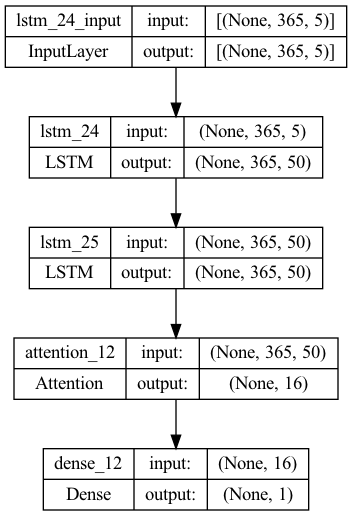

In [322]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(Attention(units=16))
model.add(Dense(1))
optimiser = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimiser, metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), coefficient_of_determination])
print(model.summary())
plot_model(model, to_file='./MagicWindowModel.png', show_shapes=True)

In [323]:
historyOne = model.fit(X_train, y_train, epochs=numEpochs//3, batch_size=batchSize, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.005)
historyTwo = model.fit(X_train, y_train, epochs=numEpochs//3, batch_size=batchSize, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.0005)
historyThree = model.fit(X_train, y_train, epochs=numEpochs//3, batch_size=batchSize, validation_data=(X_test, y_test), verbose=1)

Epoch 1/4


2022-08-13 15:17:22.489413: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


232/232 [==============================] - ETA: 0s - loss: 0.0347 - coefficient_of_determination: 0.8468

2022-08-13 15:18:00.734601: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


232/232 [==============================] - 41s 165ms/step - loss: 0.0347 - coefficient_of_determination: 0.8468 - val_loss: 0.1003 - val_coefficient_of_determination: -32.0014
Epoch 2/4
232/232 [==============================] - 38s 165ms/step - loss: 0.0115 - coefficient_of_determination: 0.9930 - val_loss: 0.0352 - val_coefficient_of_determination: -2.6293
Epoch 3/4
232/232 [==============================] - 40s 173ms/step - loss: 0.0098 - coefficient_of_determination: 0.9949 - val_loss: 0.0721 - val_coefficient_of_determination: -15.7376
Epoch 4/4
232/232 [==============================] - 41s 178ms/step - loss: 0.0116 - coefficient_of_determination: 0.9932 - val_loss: 0.0571 - val_coefficient_of_determination: -9.8640
Epoch 1/4
232/232 [==============================] - 43s 186ms/step - loss: 0.0063 - coefficient_of_determination: 0.9974 - val_loss: 0.0449 - val_coefficient_of_determination: -5.7065
Epoch 2/4
232/232 [==============================] - 42s 180ms/step - loss: 0.0062 

In [324]:
y_hat = model.predict(X_test)

2022-08-13 15:25:54.967540: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


13/13 [==============================] - 2s 53ms/step


In [325]:
# Undo normalisation
y_test = (y_test * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]
y_hat = (y_hat * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]

# Undo standardisation
y_test = (y_test * scaler.scale_[0]) + scaler.mean_[0]
y_hat = (y_hat * scaler.scale_[0]) + scaler.mean_[0]

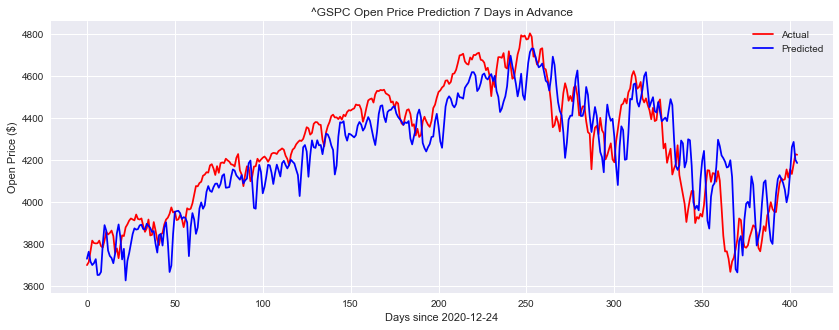

In [326]:
predictionPlotTitle = ticker + " Open Price Prediction " + str(lookAhead)
if (lookAhead == 1):
    predictionPlotTitle = predictionPlotTitle + " Day in Advance"
else:
    predictionPlotTitle = predictionPlotTitle + " Days in Advance"
xLabel = "Days since " + splitDate.strftime("%Y-%m-%d")

plt.figure(figsize=(14, 5))
plt.plot(y_test, color='red', label="Actual")
plt.plot(y_hat, color='blue', label="Predicted")
plt.title(predictionPlotTitle)
plt.xlabel(xLabel)
plt.ylabel("Open Price ($)")
plt.legend()
plt.show()

In [327]:
print(y_test[-1])
print(y_hat[-1])

4225.02001953125
[4185.593]


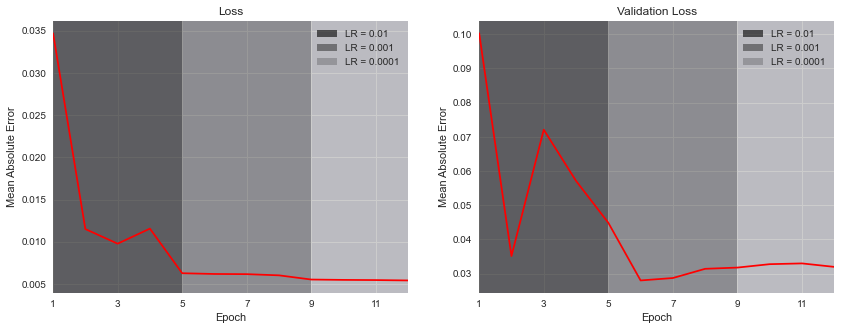

In [328]:
totalLoss = np.concatenate([historyOne.history['loss'], historyTwo.history['loss'], historyThree.history['loss']])
totaValLoss = np.concatenate([historyOne.history['val_loss'], historyTwo.history['val_loss'], historyThree.history['val_loss']])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(totalLoss, color='red')
plt.axvspan(0, numEpochs//3, facecolor='black', alpha=0.6, label="LR = 0.01")
plt.axvspan(numEpochs//3, 2*(numEpochs//3), facecolor='black', alpha=0.4, label="LR = 0.001")
plt.axvspan(2*(numEpochs//3), numEpochs-1, facecolor='black', alpha=0.2, label="LR = 0.0001")
plt.xlim(0, numEpochs-1)
plt.xticks([2*i for i in range(numEpochs//2)], [(2*j)+1 for j in range(numEpochs//2)])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(totaValLoss, color='red')
plt.axvspan(0, numEpochs//3, facecolor='black', alpha=0.6, label="LR = 0.01")
plt.axvspan(numEpochs//3, 2*(numEpochs//3), facecolor='black', alpha=0.4, label="LR = 0.001")
plt.axvspan(2*(numEpochs//3), numEpochs-1, facecolor='black', alpha=0.2, label="LR = 0.0001")
plt.xlim(0, numEpochs-1)
plt.xticks([2*i for i in range(numEpochs//2)], [(2*j)+1 for j in range(numEpochs//2)])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [329]:
mae = historyThree.history['mean_absolute_error']
mse = historyThree.history['mean_squared_error']
rmse = historyThree.history['root_mean_squared_error']
r2 = historyThree.history['coefficient_of_determination']

print('Mean Absolute Error (MAE): ' + str(mae[-1]))
print('Mean Squared Error (MSE): ' + str(mse[-1]))
print('Root Mean Squared Error (RMSE): ' + str(rmse[-1]))
print('Coefficient of Determination (R2): ' + str(r2[-1]))

KeyError: 'mean_absolute_error'

In [ ]:
valmae = historyThree.history['val_mean_absolute_error']
valmse = historyThree.history['val_mean_squared_error']
valrmse = historyThree.history['val_root_mean_squared_error']
valr2 = historyThree.history['val_coefficient_of_determination']

print('Validation Mean Absolute Error (MAE): ' + str(valmae[-1]))
print('Validation Mean Squared Error (MSE): ' + str(valmse[-1]))
print('Validation Root Mean Squared Error (RMSE): ' + str(valrmse[-1]))
print('Validation Coefficient of Determination (R2): ' + str(valr2[-1]))

Validation Mean Absolute Error (MAE): 0.028570223599672318
Validation Mean Squared Error (MSE): 0.0015200272900983691
Validation Root Mean Squared Error (RMSE): 0.038987528532743454
Validation Coefficient of Determination (R2): -0.2957489490509033


In [ ]:
finalPrediction = str(y_hat[-1])[1:-1]
currentPrice = str(y_test[-1])
percentageChange = ((y_hat[-1]-y_test[-1])/y_test[-1])*100

if (lookAhead == 1):
    print("In 1 day, I predict the " + ticker + " price to be $" + finalPrediction)
else:
    print("In " + str(lookAhead) + " days, I predict the " + ticker + " price to be $" + finalPrediction)
print("The price is currently $" + currentPrice)

In 7 days, I predict the SPY price to be $419.72125
The price is currently $422.02999877929676
